In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from utils import setup_seed
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss
from torch.utils.tensorboard import SummaryWriter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def save_summary(writer, loss_dict, global_step, tag, lr=None, momentum=None):
    for k, v in loss_dict.items():
        writer.add_scalar(f'{tag}/{k}', v, global_step)
    if lr is not None:
        writer.add_scalar('lr', lr, global_step)
    if momentum is not None:
        writer.add_scalar('momentum', momentum, global_step)

### Training Arguments

In [7]:
class Args:
    def __init__(self):
        self.data_root = "dataset/KITTI"
        self.saved_path = "logs/pillar_pruning"
        self.batch_size = 4
        self.num_workers = 4
        self.nclasses = 3
        self.init_lr = 0.00025
        self.max_epoch = 200
        self.log_freq = 8
        self.ckpt_freq_epoch = 20
        self.no_cuda = not torch.cuda.is_available()
 
args = Args()

### Dataloader

In [8]:
setup_seed()
train_dataset = Kitti(data_root=args.data_root,
                        split='train')
val_dataset = Kitti(data_root=args.data_root,
                    split='val')
train_dataloader = get_dataloader(dataset=train_dataset, 
                                    batch_size=args.batch_size, 
                                    num_workers=args.num_workers,
                                    shuffle=True)
val_dataloader = get_dataloader(dataset=val_dataset, 
                                batch_size=args.batch_size, 
                                num_workers=args.num_workers,
                                shuffle=False)

In [9]:
data_dict = val_dataset.__getitem__(8)
print(data_dict['pts'].shape)

(18200, 4)


### Model, Loss, Optimizer, Scheduler, Log

In [10]:
if not args.no_cuda:
    pointpillars = PointPillars(nclasses=args.nclasses).cuda()
else:
    pointpillars = PointPillars(nclasses=args.nclasses)

loss_func = Loss()

max_iters = 2*len(train_dataloader) * args.max_epoch
init_lr = args.init_lr
optimizer = torch.optim.AdamW(params=pointpillars.parameters(), 
                                lr=init_lr, 
                                betas=(0.95, 0.99),
                                weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,  
                                                max_lr=init_lr*10, 
                                                total_steps=max_iters, 
                                                pct_start=0.4, 
                                                anneal_strategy='cos',
                                                cycle_momentum=True, 
                                                base_momentum=0.95*0.895, 
                                                max_momentum=0.95,
                                                div_factor=10)

saved_logs_path = os.path.join(args.saved_path, 'summary')
os.makedirs(saved_logs_path, exist_ok=True)
writer = SummaryWriter(saved_logs_path)
saved_ckpt_path = os.path.join(args.saved_path, 'checkpoints')
os.makedirs(saved_ckpt_path, exist_ok=True)

In [11]:
from ptflops import get_model_complexity_info

with torch.no_grad():

    for i, data_dict in enumerate(tqdm(train_dataloader)):
        break

    if not args.no_cuda:
        # move the tensors to the cuda
        for key in data_dict:
            for j, item in enumerate(data_dict[key]):
                if torch.is_tensor(item):
                    data_dict[key][j] = data_dict[key][j].cuda()

    optimizer.zero_grad()

    batched_pts = data_dict['batched_pts']

    input_size = tuple(batched_pts[0].shape)

    macs, params = get_model_complexity_info(pointpillars, input_size, as_strings=True,
                                                 print_per_layer_stat=True, verbose=True)

    print(f"FLOPs: {macs}")
    print(f"Parameters: {params}")

# bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, \
#                 bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
#                     bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2, \
#                         anchor_target_dict = pointpillars(batched_pts=batched_pts, 
#                             mode='train',
#                             batched_gt_bboxes=batched_gt_bboxes, 
#                             batched_gt_labels=batched_labels)

  0%|          | 0/1317 [00:15<?, ?it/s]


PointPillars(
  4.83 M, 100.000% Params, 63.29 GMac, 99.922% MACs, 
  (pillar_layer): PillarLayer(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (voxel_layer): Voxelization(voxel_size=[0.16, 0.16, 4], point_cloud_range=[0, -39.68, -3, 69.12, 39.68, 1], max_num_points=32, max_voxels=(16000, 40000), deterministic=True)
  )
  (pillar_encoder): PillarEncoder(
    704, 0.015% Params, 22.53 KMac, 0.000% MACs, 
    (conv): Conv1d(576, 0.012% Params, 18.43 KMac, 0.000% MACs, 9, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, 0.003% Params, 4.1 KMac, 0.000% MACs, 64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (backbone): Backbone(
    4.21 M, 87.027% Params, 29.71 GMac, 46.904% MACs, 
    (multi_blocks): ModuleList(
      4.21 M, 87.027% Params, 29.71 GMac, 46.904% MACs, 
      (0): Sequential(
        147.97 k, 3.060% Params, 7.94 GMac, 12.536% MACs, 
        (0): Conv2d(36.86 k, 0.762% Params, 1.97 GMac, 3.118% MACs, 64, 64, kernel_size

/home/sayeed/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Training

In [14]:
training_loss0 = []

val_loss0 = []

==================== 0 ====================


  0%|          | 0/1317 [00:00<?, ?it/s]

100%|██████████| 1317/1317 [11:47<00:00,  1.86it/s]


==================== 1 ====================


100%|██████████| 217/217 [00:52<00:00,  4.12it/s]


==================== 2 ====================


100%|██████████| 1317/1317 [11:57<00:00,  1.83it/s]


==================== 3 ====================


100%|██████████| 217/217 [00:51<00:00,  4.20it/s]


==================== 4 ====================


100%|██████████| 1317/1317 [11:55<00:00,  1.84it/s]


==================== 5 ====================


100%|██████████| 217/217 [00:51<00:00,  4.23it/s]


==================== 6 ====================


100%|██████████| 1317/1317 [11:59<00:00,  1.83it/s]


==================== 7 ====================


100%|██████████| 217/217 [00:51<00:00,  4.22it/s]


==================== 8 ====================


100%|██████████| 1317/1317 [12:03<00:00,  1.82it/s]


==================== 9 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 10 ====================


100%|██████████| 1317/1317 [11:05<00:00,  1.98it/s]


==================== 11 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 12 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 13 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 14 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 15 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 16 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 17 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 18 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 19 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


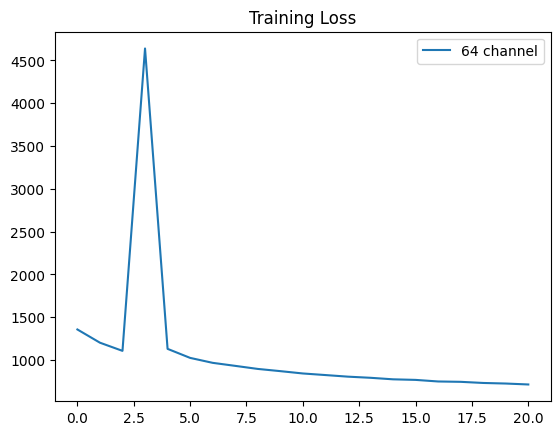

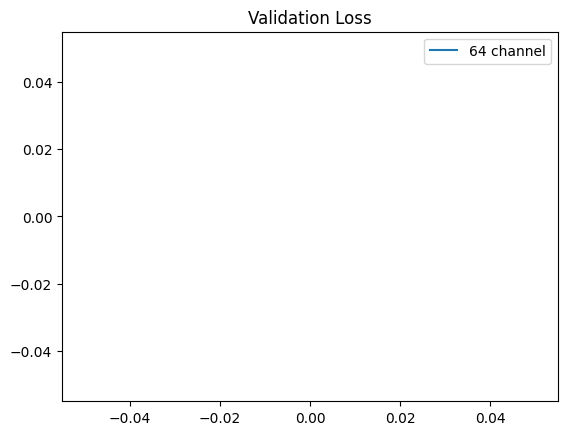

100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 20 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 21 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 22 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 23 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 24 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 25 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 26 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 27 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 28 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 29 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 30 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 31 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 32 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 33 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 34 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 35 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 36 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 37 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 38 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 39 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


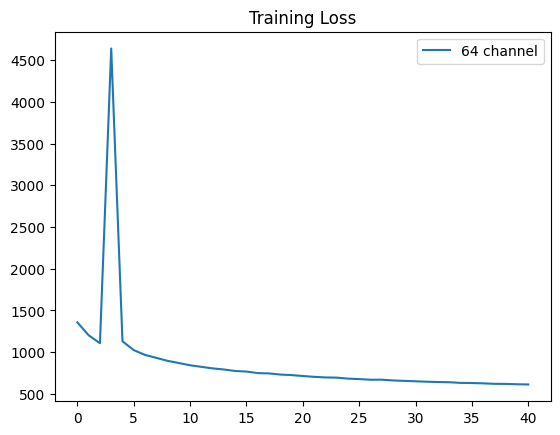

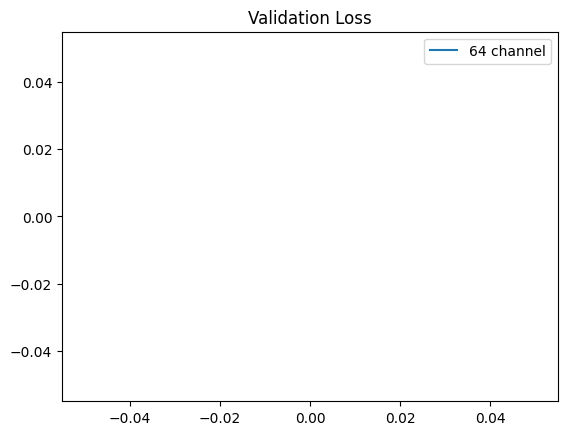

100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 40 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 41 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 42 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 43 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 44 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 45 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 46 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 47 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 48 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 49 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 50 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 51 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 52 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 53 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 54 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 55 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 56 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 57 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 58 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 59 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


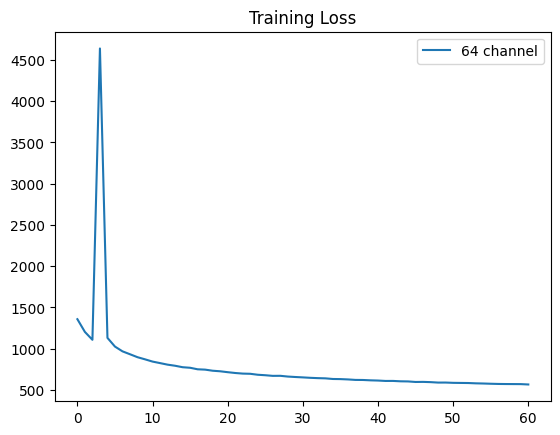

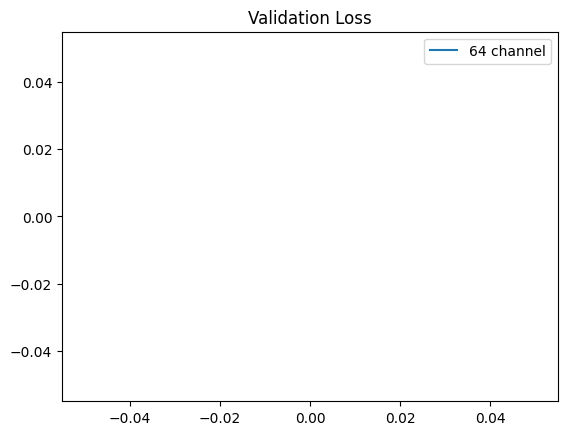

100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 60 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 61 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 62 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 63 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 64 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 65 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 66 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 67 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 68 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 69 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 70 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 71 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 72 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 73 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 74 ====================


100%|██████████| 1317/1317 [11:03<00:00,  1.99it/s]


==================== 75 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 76 ====================


100%|██████████| 1317/1317 [11:03<00:00,  1.99it/s]


==================== 77 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 78 ====================


100%|██████████| 1317/1317 [11:03<00:00,  1.98it/s]


==================== 79 ====================


100%|██████████| 1317/1317 [11:03<00:00,  1.98it/s]


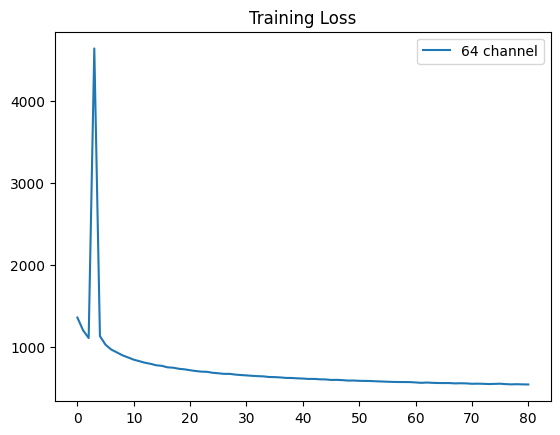

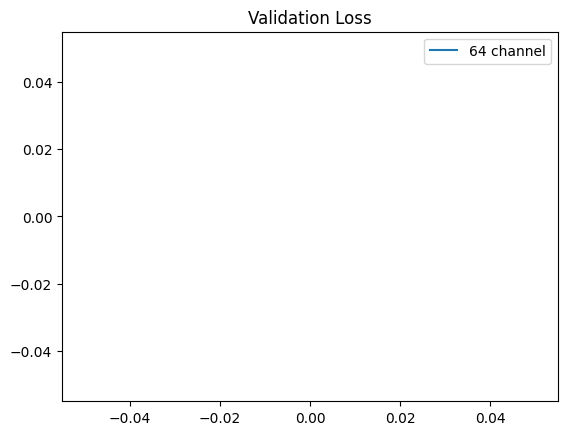

100%|██████████| 217/217 [00:47<00:00,  4.54it/s]


==================== 80 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 81 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 82 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 83 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 84 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 85 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 86 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 87 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 88 ====================


100%|██████████| 1317/1317 [11:03<00:00,  1.98it/s]


==================== 89 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 90 ====================


100%|██████████| 1317/1317 [11:03<00:00,  1.99it/s]


==================== 91 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 92 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 93 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 94 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 95 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 96 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 97 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 98 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 99 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


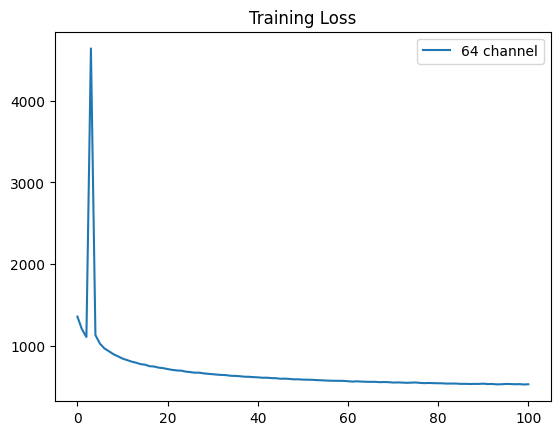

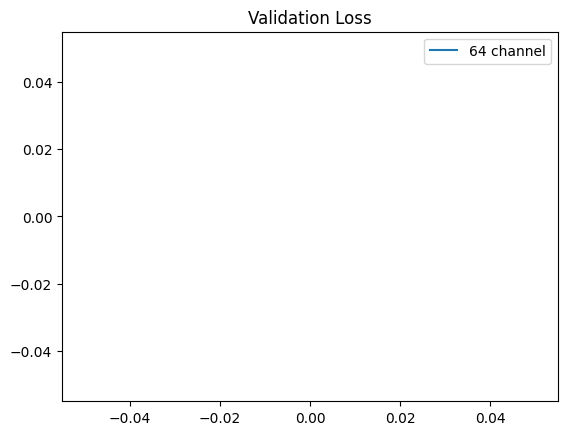

100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 100 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 101 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 102 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 103 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 104 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 105 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 106 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 107 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 108 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 109 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 110 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 111 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 112 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 113 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 114 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 115 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 116 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 117 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 118 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 119 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


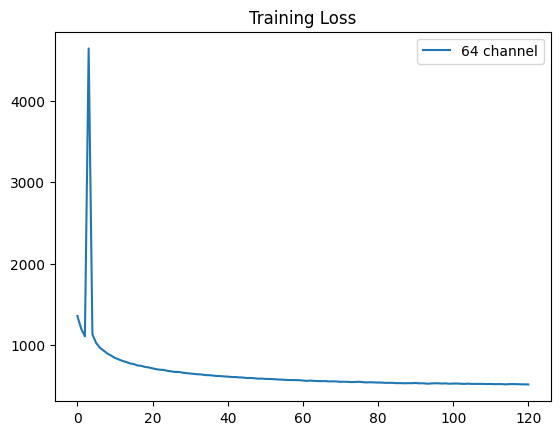

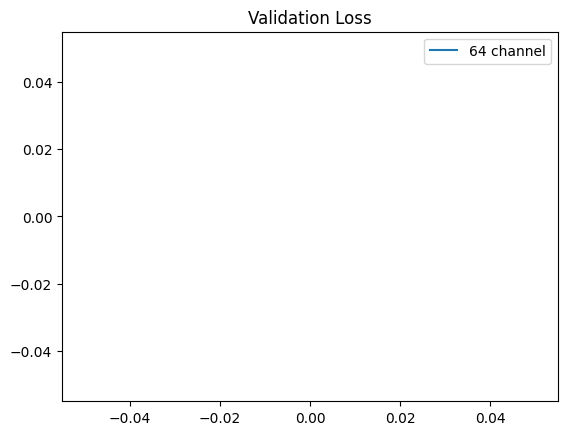

100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 120 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 121 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 122 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 123 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 124 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 125 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 126 ====================


100%|██████████| 1317/1317 [11:03<00:00,  1.98it/s]


==================== 127 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 128 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 129 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 130 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 131 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 132 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 133 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 134 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 135 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 136 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 137 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 138 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 139 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


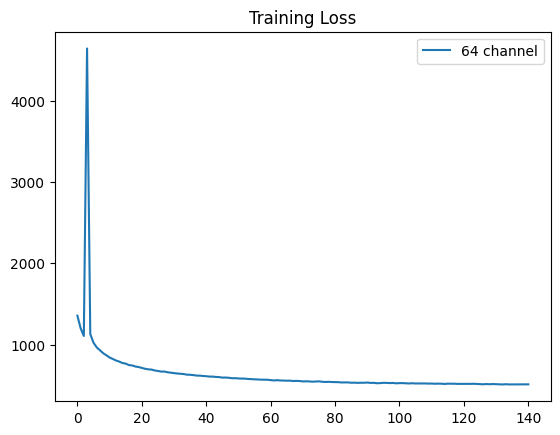

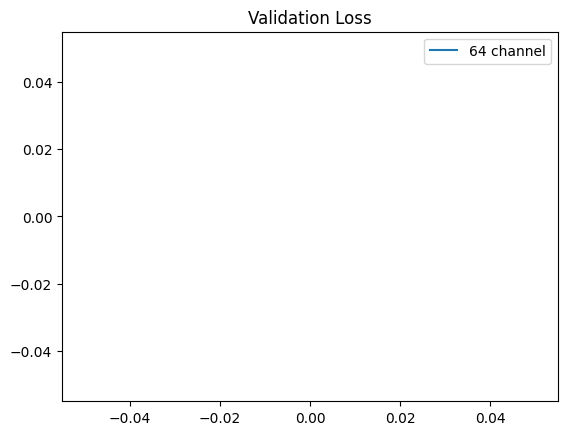

100%|██████████| 217/217 [00:47<00:00,  4.56it/s]


==================== 140 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 141 ====================


100%|██████████| 217/217 [00:47<00:00,  4.56it/s]


==================== 142 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 143 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 144 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 145 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 146 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 147 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 148 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 149 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 150 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 151 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 152 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 153 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 154 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 155 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 156 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 157 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 158 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 159 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


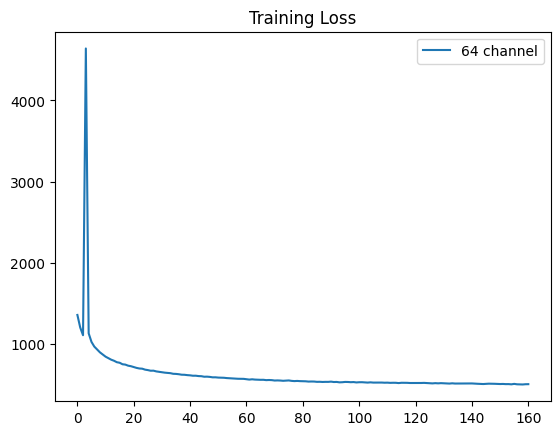

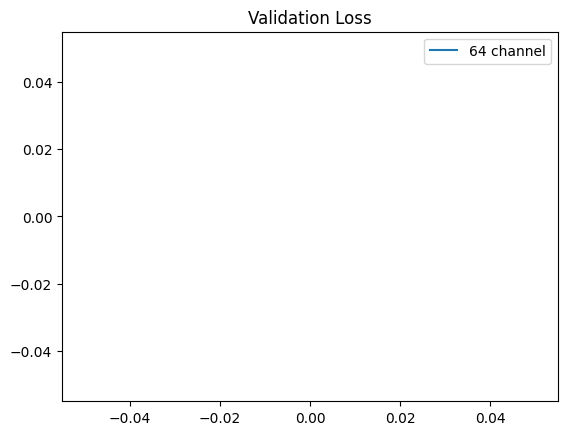

100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 160 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 161 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 162 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 163 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 164 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 165 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 166 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 167 ====================


100%|██████████| 217/217 [00:47<00:00,  4.57it/s]


==================== 168 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 169 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 170 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 171 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 172 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 173 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 174 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 175 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 176 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 177 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 178 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 179 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


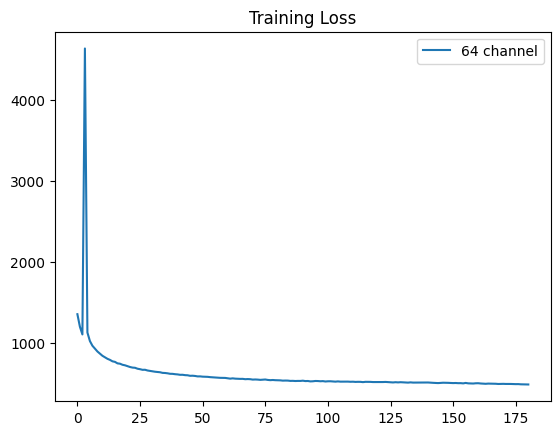

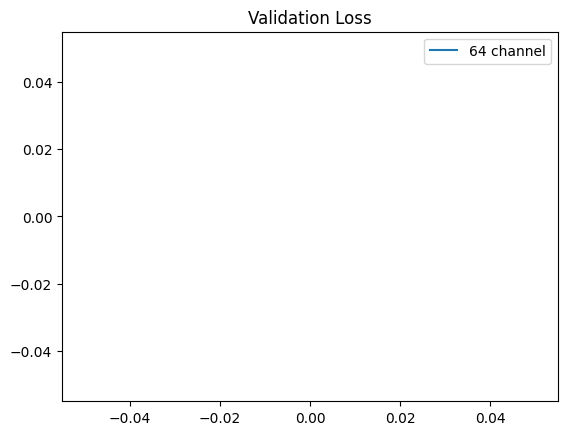

100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 180 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 181 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 182 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 183 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 184 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 185 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 186 ====================


100%|██████████| 1317/1317 [11:00<00:00,  1.99it/s]


==================== 187 ====================


100%|██████████| 217/217 [00:47<00:00,  4.58it/s]


==================== 188 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 189 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 190 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 191 ====================


100%|██████████| 217/217 [00:47<00:00,  4.59it/s]


==================== 192 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 193 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 194 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 195 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 196 ====================


100%|██████████| 1317/1317 [11:02<00:00,  1.99it/s]


==================== 197 ====================


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


==================== 198 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


==================== 199 ====================


100%|██████████| 1317/1317 [11:01<00:00,  1.99it/s]


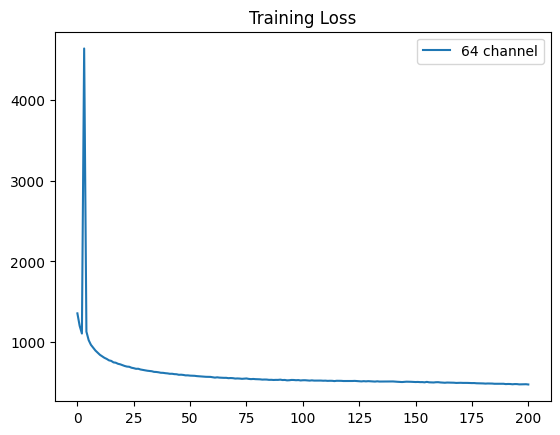

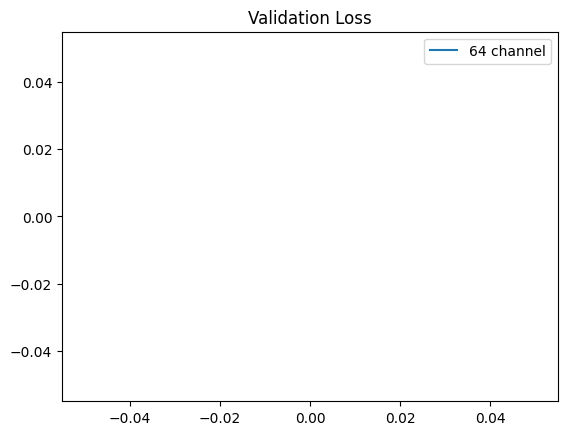

100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


In [16]:
for epoch in range(args.max_epoch):
# for epoch in range(1):
    epoch_loss0 = 0


    val_epoch_loss0 = 0


    print('=' * 20, epoch, '=' * 20)
    train_step, val_step = 0, 0
    for i, data_dict in enumerate(tqdm(train_dataloader)):
        if not args.no_cuda:
            # move the tensors to the cuda
            for key in data_dict:
                for j, item in enumerate(data_dict[key]):
                    if torch.is_tensor(item):
                        data_dict[key][j] = data_dict[key][j].cuda()
        
        optimizer.zero_grad()

        batched_pts = data_dict['batched_pts']
        batched_gt_bboxes = data_dict['batched_gt_bboxes']
        batched_labels = data_dict['batched_labels']
        batched_difficulty = data_dict['batched_difficulty']


        bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict = pointpillars(batched_pts=batched_pts, 
                                    mode='train',
                                    batched_gt_bboxes=batched_gt_bboxes, 
                                    batched_gt_labels=batched_labels)

        
        ################# Full features #################
        bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
        bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
        bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)


        batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
        batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
        batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
        batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


        
        pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

        bbox_pred0 = bbox_pred0[pos_idx]

        batched_bbox_reg = batched_bbox_reg[pos_idx]
        batched_bbox_reg0 = batched_bbox_reg.clone()


        # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
        bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())


        batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())


        bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]


        batched_dir_labels = batched_dir_labels[pos_idx]

        num_cls_pos = (batched_bbox_labels < args.nclasses).sum()

        bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


        batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
        batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

        loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                                bbox_pred=bbox_pred0,
                                bbox_dir_cls_pred=bbox_dir_cls_pred0,
                                batched_labels=batched_bbox_labels, 
                                num_cls_pos=num_cls_pos, 
                                batched_bbox_reg=batched_bbox_reg0, 
                                batched_dir_labels=batched_dir_labels)

        
        loss0 = loss_dict0['total_loss'] 

        loss = loss0 # + loss1 + loss2
        loss.backward()

        epoch_loss0 = epoch_loss0 + loss0.item()


        # torch.nn.utils.clip_grad_norm_(pointpillars.parameters(), max_norm=35)
        optimizer.step()
        scheduler.step()



        global_step = epoch * len(train_dataloader) + train_step + 1

        if global_step % args.log_freq == 0:
            save_summary(writer, loss_dict0, global_step, 'train',
                            lr=optimizer.param_groups[0]['lr'], 
                            momentum=optimizer.param_groups[0]['betas'][0])
        train_step += 1

    training_loss0.append(epoch_loss0)

    if (epoch + 1) % args.ckpt_freq_epoch == 0:
        torch.save(pointpillars.state_dict(), os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth'))

        plt.figure()
        plt.plot(np.array(training_loss0))
        plt.title("Training Loss")
        plt.legend(["64 channel"])
        plt.show()

        plt.figure()
        plt.plot(np.array(val_loss0))
        plt.title("Validation Loss")
        plt.legend(["64 channel"])
        plt.show()

    if epoch % 2 == 0:
        continue
    pointpillars.eval()
    with torch.no_grad():
        for i, data_dict in enumerate(tqdm(val_dataloader)):
            try:
                if not args.no_cuda:
                    # move the tensors to the cuda
                    for key in data_dict:
                        for j, item in enumerate(data_dict[key]):
                            if torch.is_tensor(item):
                                data_dict[key][j] = data_dict[key][j].cuda()
                
                batched_pts = data_dict['batched_pts']
                batched_gt_bboxes = data_dict['batched_gt_bboxes']
                batched_labels = data_dict['batched_labels']
                batched_difficulty = data_dict['batched_difficulty']

                bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict = pointpillars(batched_pts=batched_pts, 
                                            mode='train',
                                            batched_gt_bboxes=batched_gt_bboxes, 
                                            batched_gt_labels=batched_labels)\

                
                ################# Full features #################
                bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
                bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
                bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)



                batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
                batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
                batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
                batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


                
                pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

                bbox_pred0 = bbox_pred0[pos_idx]

                batched_bbox_reg = batched_bbox_reg[pos_idx]
                batched_bbox_reg0 = batched_bbox_reg.clone()

                # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
                bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())

                batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())


                bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]

                batched_dir_labels = batched_dir_labels[pos_idx]

                num_cls_pos = (batched_bbox_labels < args.nclasses).sum()

                bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]

                batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
                batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

                loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                                        bbox_pred=bbox_pred0,
                                        bbox_dir_cls_pred=bbox_dir_cls_pred0,
                                        batched_labels=batched_bbox_labels, 
                                        num_cls_pos=num_cls_pos, 
                                        batched_bbox_reg=batched_bbox_reg0, 
                                        batched_dir_labels=batched_dir_labels)
                
                
                loss0 = loss_dict0['total_loss'] 

                val_epoch_loss0 = val_epoch_loss0 + loss0.item()

                global_step = epoch * len(val_dataloader) + val_step + 1
                if global_step % args.log_freq == 0:
                    save_summary(writer, loss_dict0, global_step, 'val')
                val_step += 1
            
            except:
                None

    val_loss0.append(val_epoch_loss0)
            
    pointpillars.train()


In [ ]:
plt.figure()
plt.plot(np.array(training_loss0))
# plt.plot(np.array(training_loss1))
# plt.plot(np.array(training_loss2))
plt.title("Training Loss")
plt.legend(["64 channel","32 channel","16 channel"])
plt.savefig("Matryoshka_train_loss.png")
plt.show()

plt.figure()
plt.plot(np.array(val_loss0))
# plt.plot(np.array(val_loss1))
# plt.plot(np.array(val_loss2))
plt.title("Validation Loss")
plt.legend(["64 channel","32 channel","16 channel"])
plt.savefig("Matryoshka_val_loss.png")
plt.show()